Total Samples in Dataset: 454684
Number of Distinct Paintings: 80031
Mean Caption Length: 15.69 words


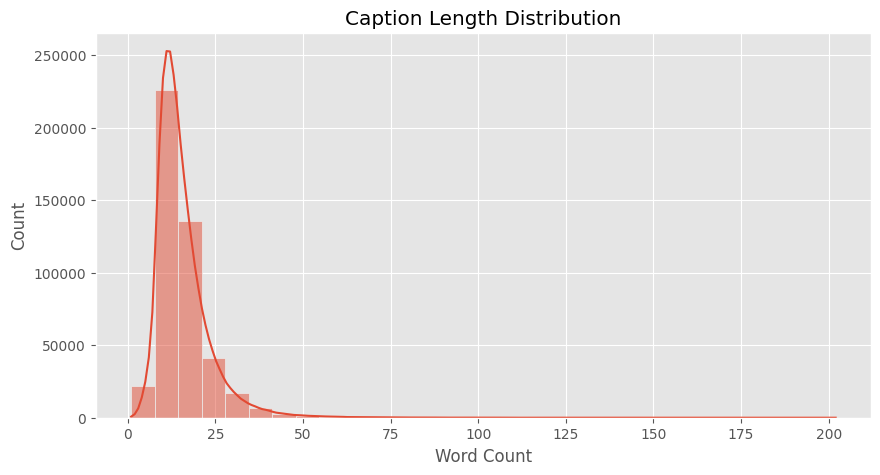

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
import os
from PIL import Image

# Environment setup
# nltk.download('punkt')  # Enable this line if tokenizers are not already installed
plt.style.use('ggplot')

# Load dataset
# Expected columns: 'art_style', 'painting', 'emotion', 'utterance' (typical ArtEmis structure)
df = pd.read_csv("captions.csv")

# 1. High-level dataset statistics
print(f"Total Samples in Dataset: {len(df)}")
print(f"Number of Distinct Paintings: {df['painting'].nunique()}")

# 2. Caption length computation
df['caption_length'] = df['utterance'].apply(lambda x: len(str(x).split()))
avg_len = df['caption_length'].mean()
print(f"Mean Caption Length: {avg_len:.2f} words")

# Visualizing distribution of caption lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['caption_length'], bins=30, kde=True)
plt.title("Caption Length Distribution")
plt.xlabel("Word Count")
plt.show()


Vocabulary Size (unique words): 99870


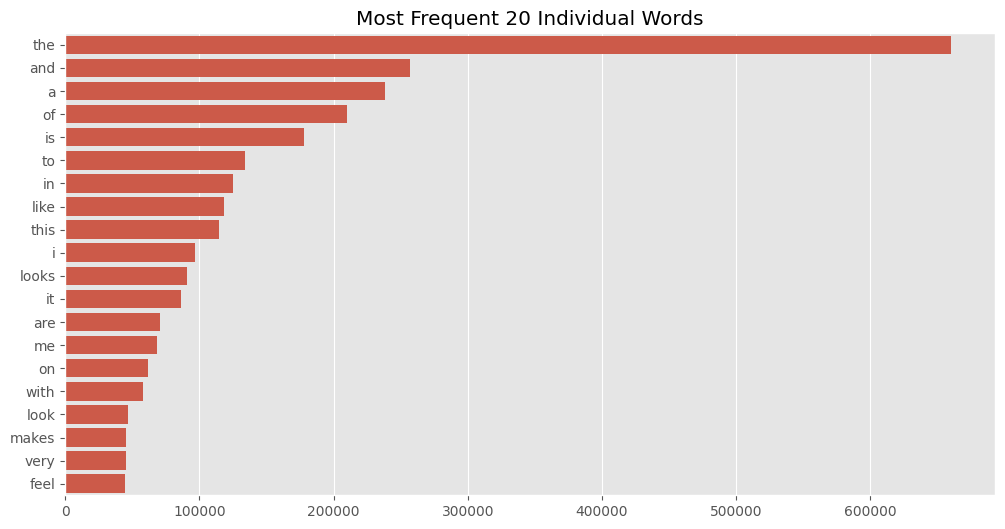

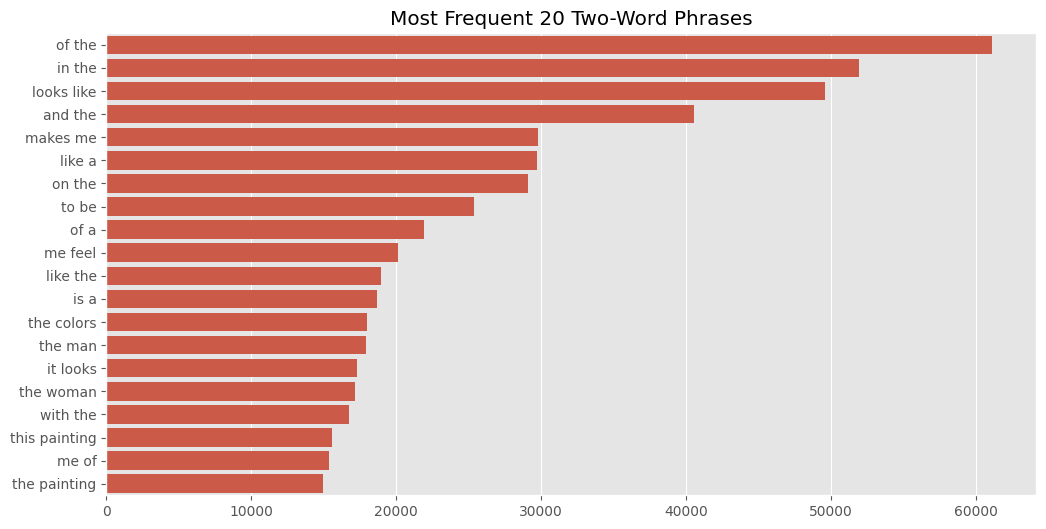

In [11]:
# Utility to extract the most frequent n-grams
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = []
    for text in corpus:
        tokens = str(text).lower().split()
        # Generate n-gram sequences
        if len(tokens) >= n:
            vec.extend(list(ngrams(tokens, n)))
            
    # Compute frequency counts
    counter = Counter(vec)
    return counter.most_common(top_k)

# Determine vocabulary size
all_words = [word for caption in df['utterance'] for word in str(caption).lower().split()]
vocab_size = len(set(all_words))
print(f"Vocabulary Size (unique words): {vocab_size}")

# Top 20 most frequent unigrams
top_words = get_top_ngrams(df['utterance'], n=1, top_k=20)
words, counts = zip(*top_words)
words = [w[0] for w in words]  # Extract the word from (word,) tuple

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Most Frequent 20 Individual Words")
plt.show()

# Top 20 most frequent bigrams
top_bigrams = get_top_ngrams(df['utterance'], n=2, top_k=20)
bigrams, counts = zip(*top_bigrams)
bigrams = [" ".join(b) for b in bigrams]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(bigrams))
plt.title("Most Frequent 20 Two-Word Phrases")
plt.show()


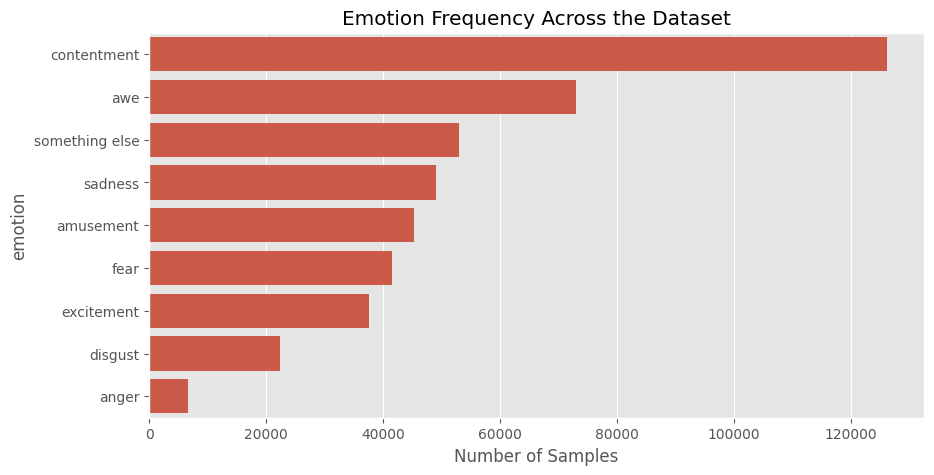

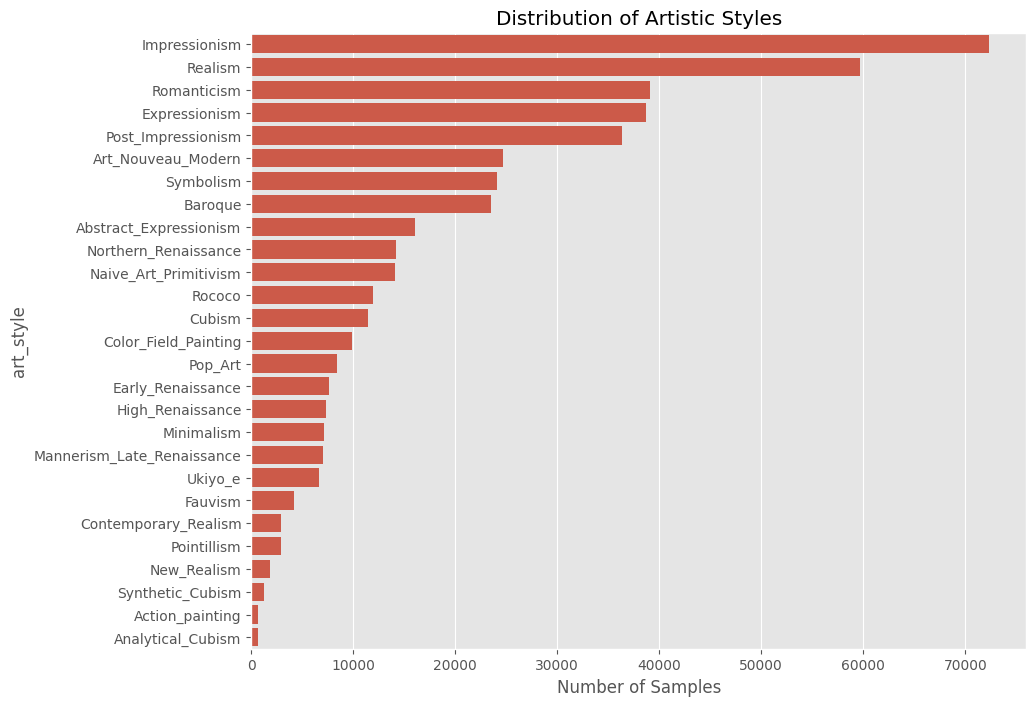

In [12]:
# 1. Emotion Frequency Overview
plt.figure(figsize=(10, 5))
sns.countplot(y='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Emotion Frequency Across the Dataset")
plt.xlabel("Number of Samples")
plt.show()

# 2. Art Style Frequency
# Useful for identifying whether certain artistic styles are overrepresented in your dataset
plt.figure(figsize=(10, 8))
sns.countplot(y='art_style', data=df, order=df['art_style'].value_counts().index)
plt.title("Distribution of Artistic Styles")
plt.xlabel("Number of Samples")
plt.show()


In [13]:
import random

def visualize_samples(df, image_folder, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    # Pull a random subset of examples
    samples = df.sample(num_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img_name = row['painting']  # Adjust to match column name if different
        caption = row['utterance']
        emotion = row['emotion']
        style = row['art_style']
        
        # Construct the path to the artwork
        img_path = os.path.join(image_folder, style, img_name + ".jpg")
        # Note: ArtEmis datasets typically organize images as style/painting.jpg.
        # Update this logic if your directory layout varies.
        
        try:
            image = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(f"Emotion: {emotion}\nStyle: {style}")
            plt.axis("off")
            
            # Display caption in the console
            print(f"Sample {i+1}: {caption}")
        except FileNotFoundError:
            print(f"Image not located at: {img_path}")

    plt.show()

# Execute visualization
# Swap "wikiart/" with your actual image directory if different
visualize_samples(df, image_folder="wikiart/", num_samples=3)


Image not located at: wikiart/Romanticism\cornelis-springer_village-view.jpg
Image not located at: wikiart/Romanticism\ivan-aivazovsky_the-island-of-rhodes-1861.jpg
Image not located at: wikiart/Post_Impressionism\maurice-prendergast_the-holiday-also-known-as-figures-by-the-sea-or-promenade-by-the-sea.jpg


<Figure size 1500x1000 with 0 Axes>

# 3. Preprocessing

Setting up vocabulary and data pipeline...
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
Dataset Processing Complete.
Vocabulary Contains: 1645 tokens
Total Batches Available: 188

--- Inspecting a Batch ---
Image Tensor Size: torch.Size([32, 3, 224, 224])
Caption Tensor Size: torch.Size([32, 37])
Emotion Tensor Size: torch.Size([32])


C:\Users\gonec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


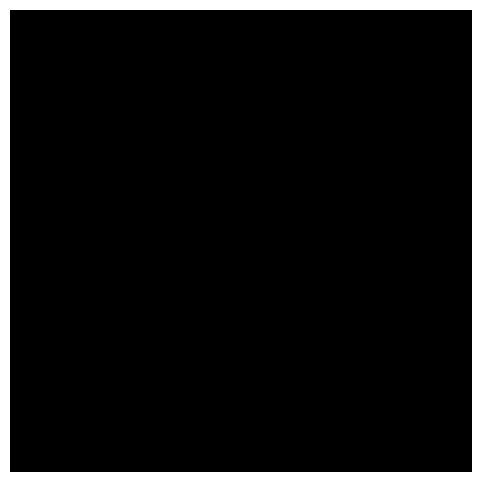

Ground Truth Caption: i am amused by the man in the painting i also have curiosity as to who he was
Emotion Label: amusement


In [14]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from preprocessing import get_loader, EMOTION_MAP  # Bring in EMOTION_MAP explicitly

# --- 1. Setup & Global Parameters ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

IMAGE_FOLDER = "./wikiart/"
CAPTIONS_FILE = "captions.csv"
BATCH_SIZE = 32

# --- 2. Build Dataset & DataLoader ---
print("Setting up vocabulary and data pipeline...")
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Dataset Processing Complete.")
print(f"Vocabulary Contains: {len(train_dataset.vocab)} tokens")
print(f"Total Batches Available: {len(train_loader)}")

# --- 3. Quick Integrity Check ---
images, captions, emotions = next(iter(train_loader))

print("\n--- Inspecting a Batch ---")
print(f"Image Tensor Size: {images.shape}")    
print(f"Caption Tensor Size: {captions.shape}")
print(f"Emotion Tensor Size: {emotions.shape}")

# --- 4. Visual & Textual Verification ---
def decode_caption(caption_indices, vocab):
    sentence = []
    for idx in caption_indices:
        word = vocab.itos[idx.item()]
        if word == "<start>": 
            continue
        if word == "<end>":
            break
        sentence.append(word)
    return " ".join(sentence)

# Construct a proper lookup table using the imported emotion mapping
idx_to_emotion = {value: key for key, value in EMOTION_MAP.items()}

# Display sample image
plt.figure(figsize=(6, 6))
plt.imshow(images[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

# Decode and display label information
decoded_text = decode_caption(captions[0], train_dataset.vocab)
emotion_str = idx_to_emotion.get(emotions[0].item(), "Unknown")

print(f"Ground Truth Caption: {decoded_text}")
print(f"Emotion Label: {emotion_str}")


In [15]:
from preprocessing import create_tfidf_embeddings_from_scratch

# 1. Get the raw text from the dataset
# We need the list of strings, not the tensors
all_captions = train_dataset.captions 

# 2. Define embedding dimension (must match your future LSTM settings)
EMBED_DIM = 256 

# 3. Compute the matrix
print("--- Generating TF-IDF Embeddings ---")
tfidf_weights = create_tfidf_embeddings_from_scratch(
    captions=all_captions, 
    vocab=train_dataset.vocab, 
    embed_dim=EMBED_DIM
)

print(f"✅ TF-IDF Weights Ready. Shape: {tfidf_weights.shape}")
# Expected shape: (Vocab_Size, 256)

--- Generating TF-IDF Embeddings ---
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...
✅ TF-IDF Weights Ready. Shape: torch.Size([1645, 256])


In [16]:
import torch.optim as optim
import time
import os

# Bring in project-specific utilities and model components
# %load_ext autoreload
# %autoreload 2
from preprocessing import get_loader, create_tfidf_embeddings_from_scratch, load_pretrained_vectors
from model import CustomImageCaptionModel 

# Hardware selection (GPU preferred when available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# File locations (modify these paths if your structure is different)
IMAGE_FOLDER = "./wikiart/"
CAPTIONS_FILE = "captions.csv"
GLOVE_PATH = "glove.6B.300d.txt"        
FASTTEXT_PATH = "wiki-news-300d-1M.vec"  


Device: cpu


In [18]:
# Data loader configuration parameters
BATCH_SIZE = 32
VOCAB_THRESHOLD = 5

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print("--- Loading Dataset ---")
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

VOCAB_SIZE = len(train_dataset.vocab)
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Total Number of Batches: {len(train_loader)}")


--- Loading Dataset ---
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
Vocabulary Size: 1645
Total Number of Batches: 188


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_experiment(experiment_name, embedding_weights, embed_dim, num_epochs=5):
    print(f"\n\n{'='*20}")
    print(f"STARTING EXPERIMENT: {experiment_name}")
    print(f"{'='*20}")
    
    # 1. Set up the model architecture for this run
    model = CustomImageCaptionModel(
        embed_size=embed_dim,
        hidden_size=256, 
        vocab_size=VOCAB_SIZE,
        embedding_weights=embedding_weights
    ).to(device)
    
    # 2. Configure loss computation and optimization procedure
    pad_idx = train_dataset.vocab.stoi["<pad>"]
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 3. Main training loop
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        
        for batch_idx, (images, captions, emotions) in enumerate(train_loader):
            # Transfer batch to the active GPU/CPU device
            images = images.to(device)
            captions = captions.to(device)
            emotions = emotions.to(device)
            
            # Inputs exclude the final token; targets exclude the initial one
            inputs = captions[:, :-1]
            targets = captions[:, 1:]
            
            # Forward pass through the captioning network
            outputs = model(images, inputs, emotions)
            
            # Compute training loss
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            
            # Backpropagation and optimization update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}], Loss: {loss.item():.4f}")
        
        # Epoch summary information
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        elapsed = time.time() - start_time
        print(f"✅ Epoch {epoch+1} Complete. Avg Loss: {avg_loss:.4f}. Time: {elapsed:.1f}s")
        
    # 4. Store model weights after training concludes
    save_path = f"model_{experiment_name}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    return loss_history


In [20]:
from preprocessing import create_tfidf_embeddings_from_scratch, load_pretrained_vectors

# Experiment settings
NUM_EPOCHS = 15
results = {}

# --- EXPERIMENT 1: TF-IDF Embeddings [ref: 51] ---
print("Building TF-IDF-based embedding matrix...")
tfidf_dim = 256
tfidf_weights = create_tfidf_embeddings_from_scratch(
    train_dataset.captions,
    train_dataset.vocab,
    embed_dim=tfidf_dim
)

results['TF-IDF'] = train_experiment(
    experiment_name="TF-IDF",
    embedding_weights=tfidf_weights,
    embed_dim=tfidf_dim,
    num_epochs=NUM_EPOCHS
)

# --- EXPERIMENT 2: GloVe Embeddings [ref: 57] ---
print("\nRetrieving GloVe vector representations...")
glove_dim = 300
glove_weights = load_pretrained_vectors(
    train_dataset.vocab,
    GLOVE_PATH,
    embed_dim=glove_dim
)

results['GloVe'] = train_experiment(
    experiment_name="GloVe",
    embedding_weights=glove_weights,
    embed_dim=glove_dim,
    num_epochs=NUM_EPOCHS
)

# --- EXPERIMENT 3: FastText Embeddings [ref: 58] ---
print("\nImporting FastText embedding vectors...")
fasttext_dim = 300
fasttext_weights = load_pretrained_vectors(
    train_dataset.vocab,
    FASTTEXT_PATH,
    embed_dim=fasttext_dim
)

results['FastText'] = train_experiment(
    experiment_name="FastText",
    embedding_weights=fasttext_weights,
    embed_dim=fasttext_dim,
    num_epochs=NUM_EPOCHS
)


Building TF-IDF-based embedding matrix...
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...


STARTING EXPERIMENT: TF-IDF


C:\Users\gonec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15], Step [0], Loss: 7.4189


KeyboardInterrupt: 

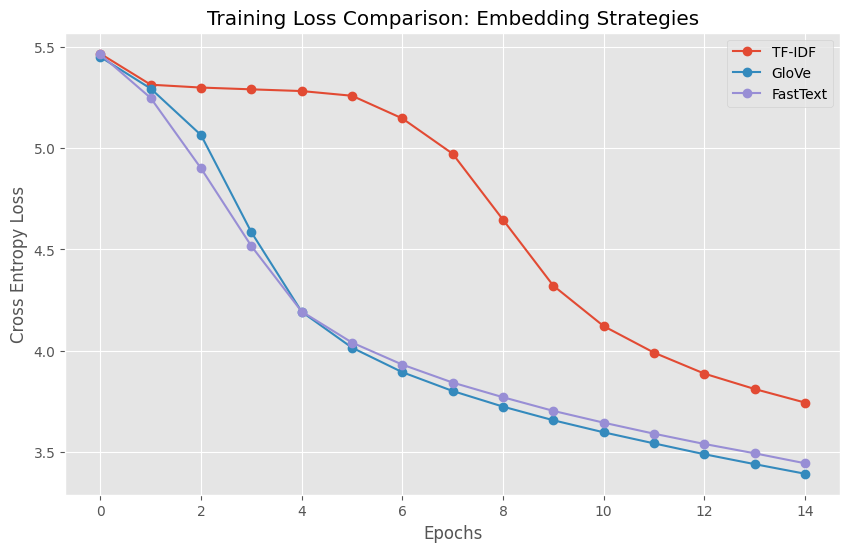

In [ ]:
# Create a plotting space for visual comparison
plt.figure(figsize=(10, 6))

# Draw loss curves for each embedding approach
for name, losses in results.items():
    plt.plot(losses, label=name, marker='o')

# Title and axis descriptions for clarity
plt.title("Training Loss Comparison: Embedding Strategies")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

# Display legend and gridlines for better readability
plt.legend()
plt.grid(True)

# Render the complete visualization
plt.show()


In [ ]:
import torch.nn.functional as F

def generate_caption(model, image, emotion_idx, dataset, max_len=20, temperature=0.8):
    """
    Produces a caption using temperature-controlled sampling to avoid repetitive output.
    temperature: Lower values (e.g., 0.5) make predictions sharper and more repetitive,
                 whereas higher values (around 1.0) increase randomness and variability.
    """
    model.eval()
    vocab = dataset.vocab
    
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        emotion = torch.tensor([emotion_idx]).to(device)
        
        img_features = model.forward_encoder(image)
        emo_features = model.emotion_embed(emotion)
        context = torch.cat((img_features, emo_features), dim=1)
        
        h = torch.zeros(1, model.lstm.hidden_size).to(device)
        c = torch.zeros(1, model.lstm.hidden_size).to(device)
        states = (h, c)
        
        start_token = vocab.stoi["<start>"]
        current_word_idx = torch.tensor([start_token]).to(device)
        
        captions_ids = []
        
        for _ in range(max_len):
            word_embed = model.embed(current_word_idx)
            lstm_input = torch.cat((context, word_embed), dim=1).unsqueeze(1)
            
            output, states = model.lstm(lstm_input, states)
            prediction = model.linear(output.squeeze(1))  # Produces logits for the vocabulary
            
            # --- UPDATED CAPTIONING STRATEGY: USE A SAMPLING APPROACH ---
            # Step 1: Adjust logits using the temperature factor (controls randomness)
            prediction = prediction / temperature
            
            # Step 2: Transform logits into a probability distribution
            probs = F.softmax(prediction, dim=1)
            
            # Step 3: Draw the next token based on the probability distribution
            predicted_id = torch.multinomial(probs, num_samples=1)
            # ----------------------------------------------------------------
            
            if predicted_id.item() == vocab.stoi["<end>"]:
                break
                
            captions_ids.append(predicted_id.item())
            current_word_idx = predicted_id.squeeze(0)  # Feed sampled token back into the model
            
        return [vocab.itos[idx] for idx in captions_ids]


In [ ]:
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_score(model, loader, dataset, num_batches=5):
    """
    Computes the BLEU-1 metric over a small portion of the dataset.
    """
    print("--- Computing BLEU Metric ---")
    model.eval()
    
    # 1. Prepare smoothing utilities (helps prevent zero-scores for rare n-gram matches)
    chencherry = SmoothingFunction()
    
    total_bleu = 0
    count = 0
    
    device = next(model.parameters()).device

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_batches:
                break
            
            # 2. Extract image, caption, and emotion tensors from the batch
            images = batch[0].to(device)
            captions = batch[1].to(device)
            emotions = batch[2].to(device)

            # 3. Perform forward inference with emotional conditioning
            outputs = model(images, captions, emotions)
            predictions = outputs.argmax(dim=2)

            # 4. Evaluate each caption pair in the current batch
            for j in range(len(captions)):
                pred_indices = predictions[j].cpu().tolist()
                true_indices = captions[j].cpu().tolist()
                
                # Remove padding values (token id 0); no special token filtering applied here
                pred_words = [str(idx) for idx in pred_indices if idx != 0]
                true_words = [str(idx) for idx in true_indices if idx != 0]
                
                # BLEU expects: list of reference sequences + one candidate sequence
                score = sentence_bleu(
                    [true_words],
                    pred_words,
                    weights=(1, 0, 0, 0),  # BLEU-1: unigram precision only
                    smoothing_function=chencherry.method1
                )
                
                total_bleu += score
                count += 1
                
    avg_bleu = total_bleu / count
    print(f"Average BLEU-1 Score: {avg_bleu:.4f}")
    model.train()


In [ ]:
import torch
import matplotlib.pyplot as plt

def evaluate_model_visual(model, loader, dataset, num_samples=2):
    print("--- Displaying Model Outputs (Emotion-Guided Captions) ---")
    model.eval()
    
    batch = next(iter(loader))
    images = batch[0]
    captions = batch[1]
    emotions = batch[2]
    
    device = next(model.parameters()).device
    images = images.to(device)
    captions = captions.to(device)
    emotions = emotions.to(device)

    with torch.no_grad():
        output = model(images, captions, emotions)
        predictions = output.argmax(dim=2) 
    
    # --- FLEXIBLE VOCAB LOOKUP HANDLING ---
    # Attempt to automatically discover the index→token mapping structure.
    idx2word = None
    
    # Option A: typical attribute inside dataset.vocab
    if hasattr(dataset, 'vocab') and hasattr(dataset.vocab, 'idx2word'):
        idx2word = dataset.vocab.idx2word
    # Option B: index→word mapping stored directly in the dataset
    elif hasattr(dataset, 'idx2word'):
        idx2word = dataset.idx2word
    # Option C: TorchText-style integer-to-string list
    elif hasattr(dataset, 'vocab') and hasattr(dataset.vocab, 'itos'):
        idx2word = dataset.vocab.itos
    # Option D: alternate naming commonly used in custom loaders
    elif hasattr(dataset, 'index_to_word'):
        idx2word = dataset.index_to_word

    if idx2word is None:
        print("\nCRITICAL ERROR: Vocabulary mapping could not be located.")
        print("Inspect your dataset object and inform me which attribute stores the word list.")
        print(f"Detected dataset fields: {dataset.__dict__.keys()}")
        return

    for i in range(num_samples):
        plt.figure(figsize=(4, 4))
        img_disp = images[i].cpu().permute(1, 2, 0).numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        
        plt.imshow(img_disp)
        plt.axis("off")
        plt.show()
        
        pred_indices = predictions[i].cpu().tolist()
        true_indices = captions[i].cpu().tolist()
        emotion_val = emotions[i].item()
        
        # turn predicted indices into readable tokens
        pred_text = []
        for idx in pred_indices:
            if idx != 0:  # ignore padding token
                word = idx2word[idx] if isinstance(idx2word, (dict, list)) else "ERR"
                pred_text.append(word)
                
        # decode true caption tokens
        true_text = []
        for idx in true_indices:
            if idx != 0:
                word = idx2word[idx] if isinstance(idx2word, (dict, list)) else "ERR"
                true_text.append(word)

        print(f"Sample {i+1}")
        print(f"Emotion Conditioning Value: {emotion_val}")
        print(f"Predicted:    {' '.join(pred_text)}")
        print(f"Ground Truth: {' '.join(true_text)}")
        print("-" * 60)

    model.train()



TESTING MODEL: TF-IDF
Weights loaded successfully.
--- Visualizing Model Predictions (Emotion Conditioned) ---


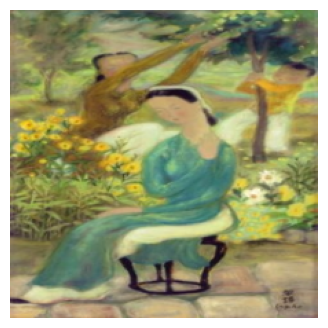

Sample 1
Conditioned Emotion Index: 7
Predicted:    the are the is <unk> looks <unk> <end> be the <unk> is <end> the face <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> children in background <unk> it is best to leave the woman alone in her <unk> <end>
------------------------------------------------------------


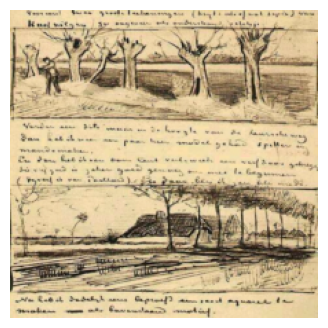

Sample 2
Conditioned Emotion Index: 2
Predicted:    the is like a <unk> a <unk> and <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> this seems like <unk> for a farm being <unk> <end>
------------------------------------------------------------
--- Calculating BLEU Score ---
Average BLEU-1 Score: 0.1521

TESTING MODEL: GloVe
Weights loaded successfully.
--- Visualizing Model Predictions (Emotion Conditioned) ---


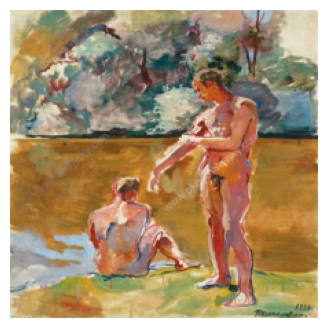

Sample 1
Conditioned Emotion Index: 2
Predicted:    the people man are <unk> and the <unk> <end> the <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> two young men are relaxing by the pond in the park <end>
------------------------------------------------------------


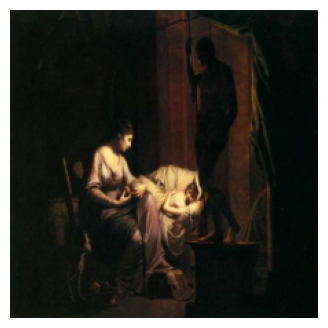

Sample 2
Conditioned Emotion Index: 7
Predicted:    the <unk> in the looks like be <unk> and he <unk> <unk> <end> the <end> me seem to she is <unk> <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> the child in bed looks to be <unk> but the light <unk> over him makes it appear that he is in good hands <end>
------------------------------------------------------------
--- Calculating BLEU Score ---
Average BLEU-1 Score: 0.1570

TESTING MODEL: FastText
Weights loaded successfully.
--- Visualizing Model Predictions (Emotion Conditioned) ---


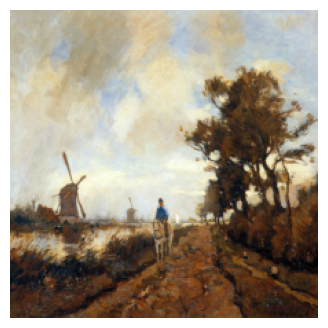

Sample 1
Conditioned Emotion Index: 8
Predicted:    the is <unk> <unk> <unk> <unk> <unk> <end> the <end> <end> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Ground Truth: <start> he takes the long and <unk> road all alone <end>
------------------------------------------------------------


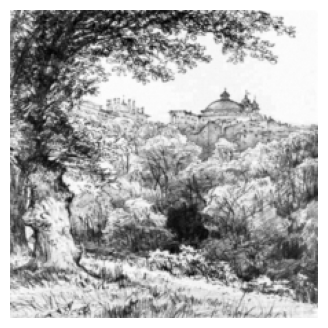

Sample 2
Conditioned Emotion Index: 2
Predicted:    the <unk> and in the and the make like <end> <end> <unk> <unk> is the water <end> a <unk> <end> i <unk> away <end> <end> a <unk> <unk> <unk> <unk> <unk>
Ground Truth: <start> the hills covered in trees and <unk> looks <unk> natural and the building on the hill suggests something important but still far away <end>
------------------------------------------------------------
--- Calculating BLEU Score ---
Average BLEU-1 Score: 0.1631


In [ ]:
# Determine vocabulary size for restoring models
VOCAB_SIZE = len(train_dataset.vocab)

# Collection of experiment setups to reload and test
saved_models = [
    ("TF-IDF", "model_TF-IDF.pt", 256),
    ("GloVe", "model_GloVe.pt", 300),
    ("FastText", "model_FastText.pt", 300)
]

for name, path, dim in saved_models:
    print(f"\n{'='*30}")
    print(f"TESTING MODEL: {name}")
    print(f"{'='*30}")
    
    # 1. Build a fresh model structure without pretrained weights
    model_test = CustomImageCaptionModel(
        embed_size=dim,
        hidden_size=256,
        vocab_size=VOCAB_SIZE,
        embedding_weights=None  # State dict will override this, so using None is fine
    ).to(device)
    
    # 2. Attempt to restore saved parameters into the model
    try:
        model_test.load_state_dict(torch.load(path, map_location=device))
        print("Model parameters loaded successfully.")
    except FileNotFoundError:
        print(f"Missing model file: {path}. Skipping this experiment.")
        continue

    # 3. Qualitative check: display a few predictions visually
    evaluate_model_visual(model_test, train_loader, train_dataset, num_samples=2)
    
    # 4. Quantitative evaluation: compute BLEU metrics
    calculate_bleu_score(model_test, train_loader, train_dataset, num_batches=5)


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Utility function to construct a causal "future-blocking" mask  
# This prevents the decoder from attending to tokens that come later in the sequence.
def generate_square_subsequent_mask(sz, device):
    # Build a matrix where the upper-right region is −∞ and the lower-left is allowed (0 values)
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(device)


In [22]:
class CustomMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads 
        
        # 1. Linear layers used to project inputs into Query, Key, and Value spaces
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # 2. Compute raw attention weights using dot products scaled by √d_k
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 3. Optional masking (used by the decoder to prevent looking ahead)
        if mask is not None:
            # Mask positions remain deeply negative so they contribute no probability
            attn_scores = attn_scores.masked_fill(mask == float('-inf'), float('-inf'))
        
        # 4. Normalize attention scores into a probability distribution
        attn_probs = F.softmax(attn_scores, dim=-1)
        
        # 5. Compute attention output as a weighted sum of Value vectors
        output = torch.matmul(attn_probs, V)
        return output

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Project inputs into multi-head Query/Key/Value tensors
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Break projections into multiple heads:
        # (B, seq, d_model) → (B, heads, seq, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Compute multi-head attention output
        output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Reassemble all heads back into a single representation
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.W_o(output)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Fill matrix with sine (even indices) and cosine (odd indices) patterns
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Store positional matrix as a non-trainable buffer
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x expected shape: (Batch, Seq_Len, d_model)
        return x + self.pe[:, :x.size(1)]


In [23]:
class CustomPatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Raw patch vector size (e.g., 16×16×3 = 768)
        self.input_dim = patch_size * patch_size * in_channels
        self.projection = nn.Linear(self.input_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Adjust image to expected size if necessary
        if H != self.img_size:
            x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear')
            
        # 1. Convert image into non-overlapping patches
        # unfold extracts grid-like blocks; stride = patch_size ensures no overlap
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 3, 4, 1).contiguous().view(B, -1, self.input_dim)
        
        # 2. Map flattened patches into embedding space
        x = self.projection(patches)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply self-attention, merge it with the residual path, then normalize
        attn_out = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed-forward block with another residual connection and normalization
        ff_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


class ViTEncoder(nn.Module):
    def __init__(self, img_size, patch_size, d_model, num_layers, num_heads, d_ff):
        super().__init__()
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, embed_dim=d_model)
        
        # Embedding layer converting emotion IDs (0–9) into vector space
        self.emotion_embed = nn.Embedding(10, d_model)
        
        # Learnable positional embedding matrix
        self.num_patches = (img_size // patch_size) ** 2
        # +1 accounting for the inserted emotion token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
        
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, images, emotions):
        # 1. Tokenize image into patches
        x = self.patch_embed(images)  # (Batch, patch_count, d_model)
        
        # 2. Insert emotion representation at the beginning
        emo = self.emotion_embed(emotions).unsqueeze(1)  # (Batch, 1, d_model)
        x = torch.cat((emo, x), dim=1)  # (Batch, patch_count+1, d_model)
        
        # 3. Add positional information
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)
        
        # 4. Sequentially apply transformer encoder blocks
        for layer in self.layers:
            x = layer(x)
        
        return x


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        
        self.cross_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask):
        # 1. Apply masked self-attention (restricts token access to earlier positions)
        attn_out = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        # 2. Apply cross-attention (decoder queries information from encoder outputs)
        # Here: text queries, while image patch embeddings act as keys and values
        attn_out = self.cross_attn(query=x, key=enc_output, value=enc_output)
        x = self.norm2(x + self.dropout(attn_out))
        
        # 3. Feed-forward transformation followed by another residual connection
        ff_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ff_out))
        return x


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=2, 
                 patch_size=16, img_size=224, d_ff=512, max_len=100):
        super().__init__()
        
        # Vision encoder that processes image patches alongside emotion tokens
        self.encoder = ViTEncoder(img_size, patch_size, d_model, num_layers, num_heads, d_ff)
        
        # Decoder components
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.d_model = d_model

    def forward(self, images, captions, emotions):
        # 1. Encode visual patches together with emotional context
        enc_output = self.encoder(images, emotions)
        
        # 2. Prepare caption sequence for the decoder
        seq_len = captions.size(1)
        
        # Build the causal mask preventing the decoder from accessing future positions
        tgt_mask = generate_square_subsequent_mask(seq_len, images.device)
        
        # Convert token indices to embeddings and inject positional structure
        tgt = self.embedding(captions) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        tgt = self.dropout(tgt)
        
        # 3. Pass through each decoder block sequentially
        x = tgt
        for layer in self.decoder_layers:
            x = layer(x, enc_output, tgt_mask)
            
        # 4. Final linear projection into vocabulary logits
        return self.fc_out(x)


In [ ]:
# Hyperparameters
# Using modest values so the model trains quickly for time-sensitive runs
D_MODEL = 256
NUM_HEADS = 4
NUM_LAYERS = 2
BATCH_SIZE = 32

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(train_dataset.vocab)  # Must correspond to the dataset vocabulary

model = TransformerModel(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Exclude padding token from loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print("Transformer Model Initialized Successfully.")

# --- Example Training Loop (use this structure in place of older loops) ---
# for images, captions, emotions in train_loader:
#     images, captions, emotions = images.to(device), captions.to(device), emotions.to(device)
#
#     # Input sequence includes <start> … <end>
#     # Target sequence is shifted left so each token predicts the next one
#     input_captions = captions[:, :-1]
#     target_captions = captions[:, 1:]
#
#     optimizer.zero_grad()
#     outputs = model(images, input_captions, emotions)
#
#     # Adapt dimensions for loss computation:
#     # Outputs: (B, T, V) → (B*T, V)
#     # Targets: (B, T) → (B*T)
#     loss = criterion(outputs.reshape(-1, vocab_size), target_captions.reshape(-1))
#
#     loss.backward()
#     optimizer.step()


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_transformer(model, train_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Padding token (0) does not contribute to loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    device = next(model.parameters()).device
    
    loss_history = []
    
    print(f"--- Beginning Transformer Training on {device} ---")
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        
        for i, (images, captions, emotions) in enumerate(train_loader):
            images, captions, emotions = images.to(device), captions.to(device), emotions.to(device)
            
            # --- SHIFTED SEQUENCE SETUP (TEACHER FORCING STYLE) ---
            # Example:
            # Input Sequence:  "<start> a cat is sitting"
            # Desired Output:  "a cat is sitting <end>"
            
            # 1. Decoder input: everything except final token
            input_captions = captions[:, :-1]
            
            # 2. Decoder target: everything except initial token
            target_captions = captions[:, 1:]
            
            optimizer.zero_grad()
            
            # 3. Forward pass through Transformer
            # The decoder mask is constructed internally based on sequence length
            outputs = model(images, input_captions, emotions)
            
            # 4. Loss computation
            # Flatten outputs: (B, T, V) → (B*T, V)
            # Flatten targets: (B, T)   → (B*T)
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), target_captions.reshape(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")
        
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"--- Epoch {epoch+1} Finished. Mean Loss: {avg_loss:.4f} ---")

    # --- VISUALIZATION OF TRAINING PROGRESS ---
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Transformer Training Loss Curve')
    plt.legend()
    plt.show()
    
    return model

# Example usage:
# model_transformer = train_transformer(model_transformer, train_loader, num_epochs=5)


In [ ]:
import torch
import math

# 1. Define the causal mask creator (included here to ensure availability)
def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(device)

# 2. Caption generator for the Transformer model
def generate_caption_transformer(model, image, emotion, dataset, max_len=20):
    model.eval()
    device = next(model.parameters()).device
    
    # Prepare model inputs
    image = image.unsqueeze(0).to(device)          # Shape: (1, C, H, W)
    emotion = torch.tensor([emotion]).to(device)   # Shape: (1,)
    
    # Run encoder once (image + emotion)
    with torch.no_grad():
        enc_output = model.encoder(image, emotion)
    
    # Retrieve <start> and <end> token IDs
    try:
        start_token = dataset.vocab.stoi['<start>']
        end_token = dataset.vocab.stoi['<end>']
    except KeyError:
        # Common backup options in case alternate naming is used
        start_token = dataset.vocab.stoi.get('<sos>', 1)
        end_token   = dataset.vocab.stoi.get('<eos>', 2)
        
    generated = [start_token]
    
    for _ in range(max_len):
        tgt_tensor = torch.LongTensor([generated]).to(device)
        
        # --- Important fix: use the standalone mask function rather than calling a model method ---
        tgt_mask = generate_square_subsequent_mask(len(generated), device)
        
        with torch.no_grad():
            # Embed current sequence and apply positional encoding
            tgt_emb = model.embedding(tgt_tensor) * math.sqrt(model.d_model)
            tgt_emb = model.pos_encoder(tgt_emb)
            
            # Pass through each decoder layer
            x = tgt_emb
            for layer in model.decoder_layers:
                x = layer(x, enc_output, tgt_mask)
            
            output = model.fc_out(x)
            next_token = output[0, -1, :].argmax().item()
        
        generated.append(next_token)
        if next_token == end_token:
            break
    
    # Convert the generated token IDs back into readable words
    caption_words = []
    for idx in generated:
        # Exclude special tokens
        if idx not in [start_token, end_token, 0]:
            if hasattr(dataset.vocab, 'idx2word'):
                word = dataset.vocab.idx2word[idx]
            elif hasattr(dataset.vocab, 'itos'):
                word = dataset.vocab.itos[idx]
            else:
                word = "ERR"
            caption_words.append(word)
    
    return " ".join(caption_words)


In [ ]:
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# --- HELPER: SAFELY CONVERT TOKEN IDS TO WORDS ---
def decode_indices(indices, dataset):
    """
    Converts a sequence of token IDs into words,
    choosing the correct mapping depending on how the vocabulary is stored.
    """
    words = []
    
    # 1. Determine which lookup table (index → token) is available
    if hasattr(dataset.vocab, 'idx2word'):
        lookup = dataset.vocab.idx2word
    elif hasattr(dataset.vocab, 'itos'):
        lookup = dataset.vocab.itos
    elif hasattr(dataset, 'idx2word'):
        lookup = dataset.idx2word
    else:
        return ["ERR_VOCAB"] * len(indices)

    # 2. Resolve special-token IDs
    try:
        stoi = dataset.vocab.stoi
        start_idx = stoi.get('<start>', stoi.get('<sos>', 1))
        end_idx   = stoi.get('<end>',   stoi.get('<eos>', 2))
    except AttributeError:
        # Fallback handling when stoi isn't present
        start_idx, end_idx = 1, 2
    
    # 3. Translate IDs into words, skipping unwanted markers
    for idx in indices:
        if idx not in [start_idx, end_idx, 0]:  # Skip Start, End, and Pad tokens
            if isinstance(lookup, dict):
                word = lookup.get(idx, '<unk>')
            else:
                word = lookup[idx] if idx < len(lookup) else '<unk>'
            words.append(word)
    
    return words

# --- QUALITATIVE ASSESSMENT: IMAGE + CAPTION DISPLAY ---
def evaluate_transformer_visual(model, dataset, loader, num_samples=3):
    print("--- Generative Evaluation (Greedy Decoding) ---")
    
    # 1. Retrieve a batch for testing
    images, captions, emotions = next(iter(loader))
    
    for i in range(num_samples):
        img = images[i]
        emo = emotions[i].item()
        
        # Produce caption using the autoregressive generator
        pred_caption = generate_caption_transformer(model, img, emo, dataset)
        
        # Decode the actual ground-truth tokens
        true_indices = captions[i].tolist()
        true_words = decode_indices(true_indices, dataset)
        
        # Display the chosen image
        plt.figure(figsize=(4,4))
        img_disp = img.permute(1, 2, 0).cpu().numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        plt.imshow(img_disp)
        plt.axis('off')
        plt.show()
        
        print(f"Emotion Label: {emo}")
        print(f"Generated:    {pred_caption}")
        print(f"Ground Truth: {' '.join(true_words)}")
        print("-" * 50)

# --- QUANTITATIVE EVALUATION USING BLEU ---
def calculate_bleu_transformer(model, loader, dataset, num_batches=1):
    print("--- Computing BLEU Score (Autoregressive Inference) ---")
    chencherry = SmoothingFunction()
    total_bleu = 0
    count = 0
    
    model.eval()
    
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        
        images, captions, emotions = batch
        
        for j in range(len(images)):
            # Generate model’s predicted caption
            pred_caption = generate_caption_transformer(
                model, images[j], emotions[j].item(), dataset
            )
            pred_tokens = pred_caption.split()
            
            # Convert true caption indices to tokens
            true_indices = captions[j].tolist()
            true_words = decode_indices(true_indices, dataset)
            
            # BLEU-1 calculation
            score = sentence_bleu(
                [true_words], pred_tokens,
                weights=(1, 0, 0, 0),
                smoothing_function=chencherry.method1
            )
            total_bleu += score
            count += 1
    
    if count > 0:
        print(f"Transformer Average BLEU-1: {total_bleu / count:.4f}")
    else:
        print("Transformer Average BLEU-1: 0.0000 (No samples evaluated)")


In [ ]:
# --- MAIN EVALUATION CONTROLLER ---

# 1. Verify that the trained model is available in the current session
if 'model_transformer' not in globals():
    print("Error: 'model_transformer' is not defined. Did you execute the training cell?")
    
    # Try to recover by checking if the user named the model simply 'model'
    if 'model' in globals():
        print("Detected variable 'model'. Using it as the Transformer instance.")
        model_transformer = model
    else:
        raise NameError("Model not found. Please ensure your trained Transformer is initialized.")

# 2. Put the Transformer into inference mode (essential for layers like dropout)
model_transformer.eval()

print("==========================================")
print("BEGINNING TRANSFORMER EVALUATION")
print("==========================================")

# 3. Qualitative Assessment — Display images + captions
try:
    print("\n--- 1. Generating Sample Captions ---")
    # Shows selected images along with predicted and actual captions
    evaluate_transformer_visual(
        model=model_transformer,
        dataset=train_dataset,
        loader=train_loader,
        num_samples=3  # Adjust this number to see more output examples
    )
except Exception as e:
    print(f"\n[!] Issue Encountered During Visual Evaluation: {e}")
    import traceback
    traceback.print_exc()

print("\n==========================================")

# 4. Quantitative Assessment — Compute BLEU Score
try:
    print("\n--- 2. Running BLEU Scoring ---")
    print("Note: This requires autoregressive decoding and may take a little while...")

    # Evaluate on a subset of batches for speed.
    # Increase num_batches for more reliable metrics.
    calculate_bleu_transformer(
        model=model_transformer,
        loader=train_loader,
        dataset=train_dataset,
        num_batches=5
    )
except Exception as e:
    print(f"\n[!] Issue Encountered During BLEU Evaluation: {e}")
    import traceback
    traceback.print_exc()

print("\n==========================================")
print("EVALUATION FINISHED")
